<a href="https://colab.research.google.com/github/PengJuan-AI/TensorFlow_Study/blob/main/TensorFlow_image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [2]:
(train_data, val_data, test_data), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info = True,
    as_supervised=True
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
num_classes = metadata.features['label'].num_classes
num_classes

5

In [6]:
get_label_name = metadata.features['label'].int2str
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=int64, num_classes=5)>

Text(0.5, 1.0, 'tulips')

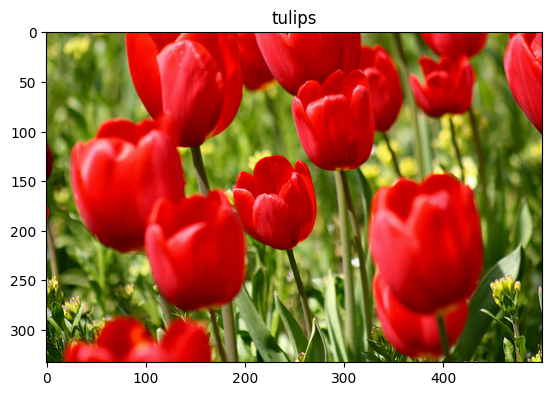

In [25]:
image, label = next(iter(train_data))
plt.imshow(image)
plt.title(get_label_name(label))

## Resize and reshape/rescale

Rescaling pixel valus to between 0 and 1.

In [15]:
IMG_SIZE=180

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1/255.)
])

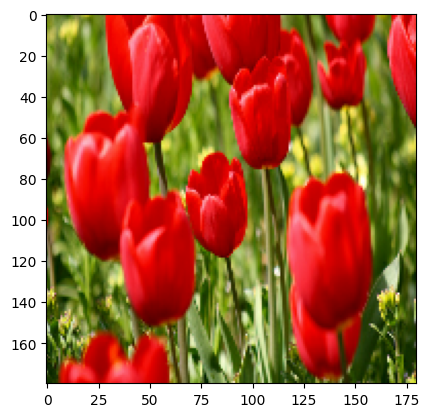

In [16]:
img1 = resize_and_rescale(image)
plt.imshow(img1)

In [19]:
img1.shape

TensorShape([180, 180, 3])

## Data augmentation

`tf.keras.layers.RandomFlip`    
`tf.keras.layers.RandomRotation`
`tf.keras.layers.RandomContrast`  
`tf.keras.layers.RandomCrop`  
`tf.keras.layers.RandomZoom`  

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [26]:
# Add the image to a batch
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image.shape

TensorShape([1, 333, 500, 3])

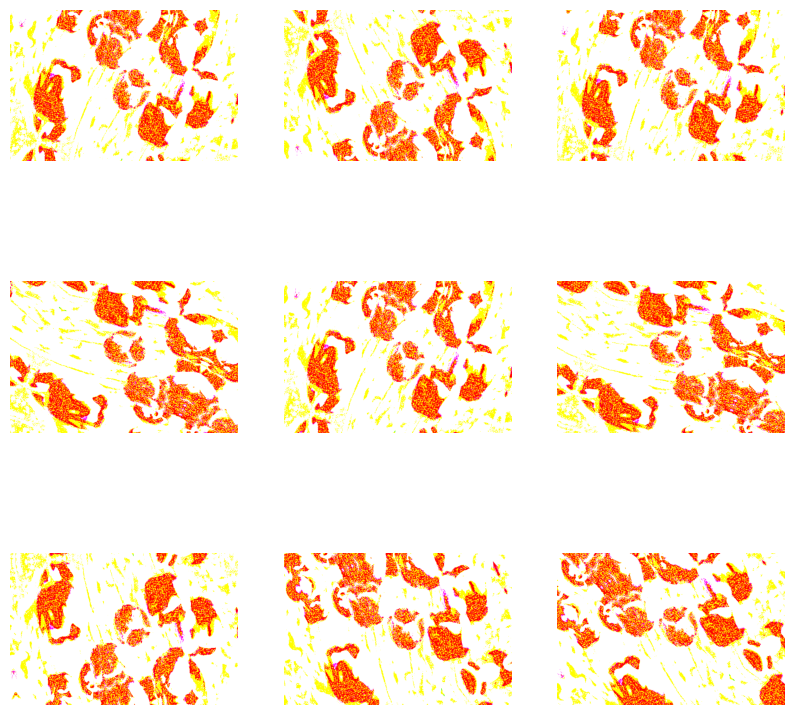

In [27]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## Two ways to apply preprocessing layers

### Include preprocessing layer into model

* When using `model.save`, preprocessing layers and model will all be saved together. If you later deploy this model, it will automatically standardize images.
* Data augmentation will be activated during calls to `model.fit`.

In [28]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
])

### Apply the preprocessing layers to your dataset

Use `dataset.map`

In this case the preprocessing layers will not be exported with the model when you call `model.save`.

**Note:** Data augmentation should only be applied to the training set.

In [31]:
aug_data = train_data.map(
    lambda x,y: (resize_and_rescale(x, training=True), y)
)

In [32]:
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
batch_size=32
AUTOTUNE = tf.data.AUTOTUNE

In [33]:
def prepare(data, shuffle=False, augment=False):
  # Resize and rescale
  ds = data.map(lambda x,y: (resize_and_rescale(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)


In [39]:
train_ds = prepare(train_data, shuffle=True, augment=True)
val_ds = prepare(val_data)
test_ds = prepare(test_data)

In [34]:
num_classes

5

In [41]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 149s 2s/step - loss: 1.2533 - accuracy: 0.4659 - val_loss: 1.0557 - val_accuracy: 0.6022
Epoch 2/5
92/92 [==============================] - 119s 1s/step - loss: 1.0391 - accuracy: 0.5746 - val_loss: 1.0843 - val_accuracy: 0.5940
Epoch 3/5
92/92 [==============================] - 117s 1s/step - loss: 0.9711 - accuracy: 0.6100 - val_loss: 0.9288 - val_accuracy: 0.6349
Epoch 4/5
92/92 [==============================] - 118s 1s/step - loss: 0.9040 - accuracy: 0.6356 - val_loss: 0.9672 - val_accuracy: 0.6376
Epoch 5/5
92/92 [==============================] - 117s 1s/step - loss: 0.8715 - accuracy: 0.6553 - val_loss: 0.8892 - val_accuracy: 0.6458


In [44]:
loss, acc = model.evaluate(test_ds)
acc

12/12 [==============================] - 5s 313ms/step - loss: 0.8382 - accuracy: 0.6567


0.6566757559776306

## Data augmentation

In [46]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

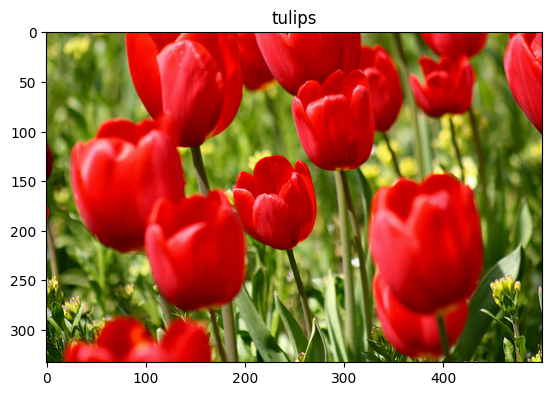

In [47]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [48]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Flip an image

`tf.image.flip_left_right`

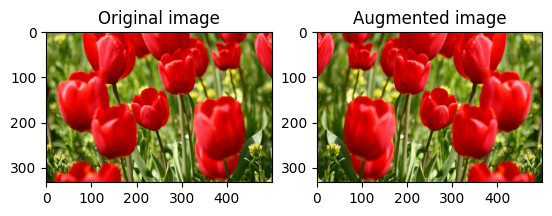

In [50]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

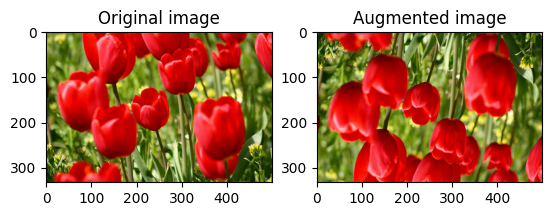

In [51]:
flipped = tf.image.flip_up_down(image)
visualize(image, flipped)

### Grayscale an image

`tf.image.rgb_to_grayscale`

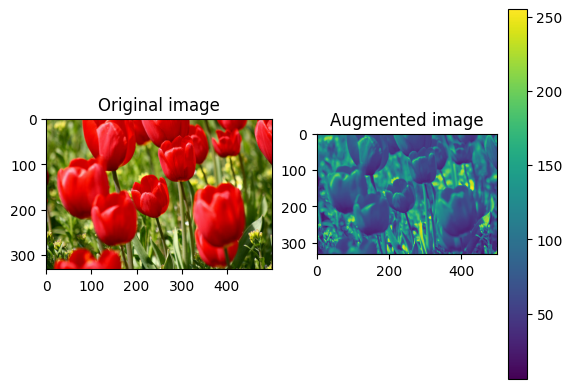

In [52]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, grayscaled)
plt.colorbar()

### Saturate an image

`tf.image.adjust_saturation`

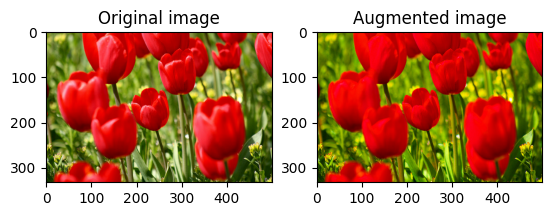

In [53]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

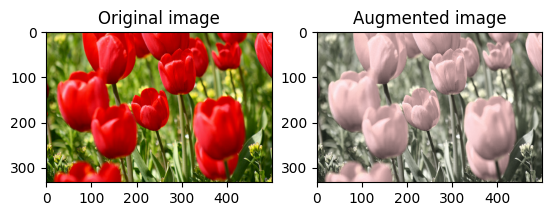

In [54]:
saturated = tf.image.adjust_saturation(image, 0.2)
visualize(image, saturated)

### Change image brightness

`tf.image.adjust_brightness`

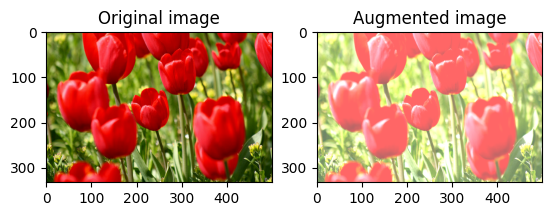

In [55]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### Center crop an image
Crop the image from center up to the image part you desire using `tf.image.central_crop`

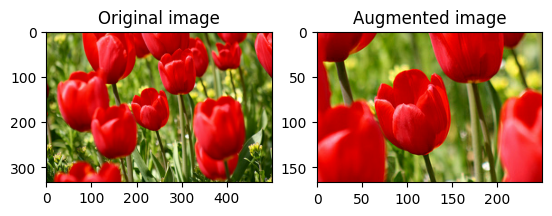

In [56]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

### Rotate an image

Rotate an image by 90 degrees: `tf.image.rot90`

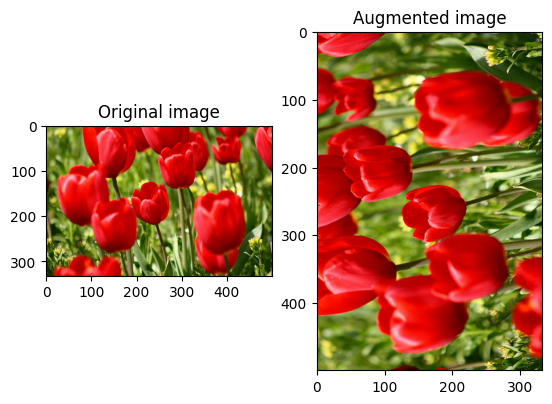

In [57]:
rotated_90 = tf.image.rot90(image)
visualize(image, rotated_90)

## Random Transformation

Applying random transformations to the images can further help generalize and expand the dataset. The current `tf.image` API provides eight such random image operations (ops):

* `tf.image.stateless_random_brightness`
* `tf.image.stateless_random_contrast`
* `tf.image.stateless_random_crop`
* `tf.image.stateless_random_flip_left_right`
* `tf.image.stateless_random_flip_up_down`
* `tf.image.stateless_random_hue`
* `tf.image.stateless_random_jpeg_quality`
* `tf.image.stateless_random_saturation`


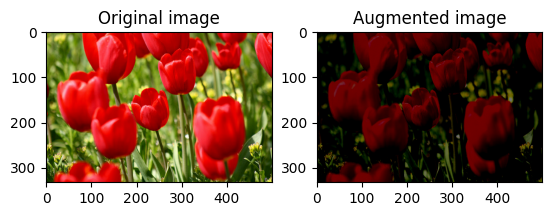

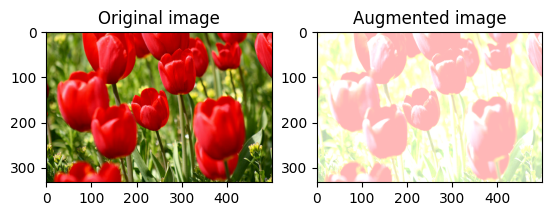

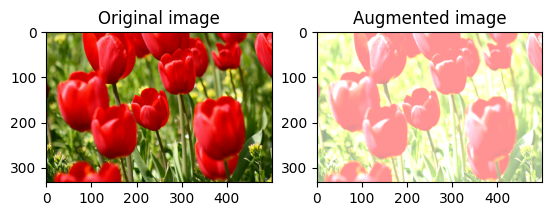

In [58]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)